# Experiment - FiQa
*[Source](https://sites.google.com/view/fiqa/home)*

In [1]:
NAME = '09-02_experiment_fiqa'
PROJECT = 'conference-calls-sentiment'
PYTHON_VERSION = '3.7.0'

### Imports

In [2]:
import os
import re
import pickle
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
from utils import accuracy_f1_score, plot_confusion_matrix

# FinBERT
import torch
from torch.utils.data import TensorDataset, DataLoader
from finbert_utils import preprocess_for_finbert, finbert_predict

Using GPU GeForce GTX 1060 6GB


### Settings

In [6]:
%config InlineBackend.figure_formats = ['svg']

In [7]:
workdir = re.sub("(?<={})[\w\W]*".format(PROJECT), "", os.getcwd())
os.chdir(workdir)

pipeline = os.path.join('2_pipeline', NAME)
if not os.path.exists(pipeline):
    os.makedirs(pipeline)
    for folder in ['out', 'store', 'tmp']:
        os.makedirs(os.path.join(pipeline, folder))

---
# Main code

In [8]:
NEUTRAL_THRESHOLD = 0.2

In [9]:
REPLACE_BY_SPACE = re.compile(r'[/(){}\[\]\|@,;-]')
BAD_SYMBOLS = re.compile(r'[^0-9a-z +_]')
HYPERLINKS = re.compile(r'(http)([^\s]+)')

def clean_text(transcript):
    transcript = transcript.lower()
    transcript = HYPERLINKS.sub('', transcript)
    transcript = REPLACE_BY_SPACE.sub(' ', transcript)
    transcript = BAD_SYMBOLS.sub('', transcript)
    transcript = re.sub(r'\s+', ' ', transcript)
    return transcript.strip()

In [10]:
headlines = pd.read_json(os.path.join('0_data', 'fiqa', 'task1_headline_ABSA_train.json')).transpose()

In [11]:
headlines['sentence'] = headlines['sentence'].apply(clean_text)

headlines['sentiment_score'] = (headlines['info']
                                .apply(lambda x: x[0]['sentiment_score'])
                                .astype(np.float))

headlines.loc[np.abs(headlines['sentiment_score']) <= NEUTRAL_THRESHOLD, 'label'] = 'neutral'
headlines.loc[headlines['sentiment_score'] > NEUTRAL_THRESHOLD, 'label'] = 'positive'
headlines.loc[headlines['sentiment_score'] < -NEUTRAL_THRESHOLD, 'label'] = 'negative'

headlines.drop(columns=['info'], inplace=True)

headlines['label'].value_counts()

positive    208
neutral     121
negative    107
Name: label, dtype: int64

In [12]:
posts = pd.read_json(os.path.join('0_data', 'fiqa', 'task1_post_ABSA_train.json')).transpose()

In [13]:
posts['sentence'] = posts['sentence'].apply(clean_text)

posts['sentiment_score'] = (posts['info']
                            .apply(lambda x: x[0]['sentiment_score'])
                            .astype(np.float))

posts.loc[np.abs(posts['sentiment_score']) <= NEUTRAL_THRESHOLD, 'label'] = 'neutral'
posts.loc[posts['sentiment_score'] > NEUTRAL_THRESHOLD, 'label'] = 'positive'
posts.loc[posts['sentiment_score'] < -NEUTRAL_THRESHOLD, 'label'] = 'negative'

posts.drop(columns=['info'], inplace=True)

posts['label'].value_counts()

positive    398
negative    203
neutral      74
Name: label, dtype: int64

## Models
### Harvard IV-4

In [14]:
with open(os.path.join('2_pipeline', '03-01_model_dictionaries', 'out', 'iv4_positive.pickle'), 'rb') as f:
    iv4_positive = pickle.load(f)

with open(os.path.join('2_pipeline', '03-01_model_dictionaries', 'out', 'iv4_negative.pickle'), 'rb') as f:
    iv4_negative = pickle.load(f)

print(f"# Positive: {len(iv4_positive)}\n# Negative: {len(iv4_negative)}")

# Positive: 1563
# Negative: 1892


### Loughran & McDonald (2011)

In [15]:
with open(os.path.join('2_pipeline', '03-01_model_dictionaries', 'out', 'lm_positive.pickle'), 'rb') as f:
    lm_positive = pickle.load(f)

with open(os.path.join('2_pipeline', '03-01_model_dictionaries', 'out', 'lm_negative.pickle'), 'rb') as f:
    lm_negative = pickle.load(f)

print(f"# Positive: {len(lm_positive)}\n# Negative: {len(lm_negative)}")

# Positive: 354
# Negative: 2355


### FinBERT

In [16]:
FINBERT_VOCAB = os.path.join('0_data', 'finbert', 'finbert_vocab')
finbert = torch.load(os.path.join('2_pipeline', '03-02_model_finbert', 'out', 'finbert'))

## Functions

In [17]:
def count_from_list(sentence, word_list):
    sentence_words = sentence.lower().split()
    num = 0
    for word in word_list:
        num += sentence_words.count(word)
    return num

def get_sentiment(row):
    if row['num_positive'] == row['num_negative']:
        return 'neutral'
    elif row['num_positive'] > row['num_negative']:
        return 'positive'
    else:
        return 'negative'

## Headlines

### IV-4 Harvard

Accuracy: 44.27%
F1-score: 45.23%


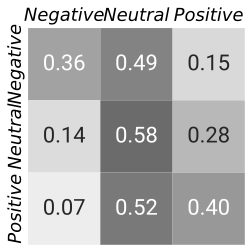

In [18]:
headlines['num_negative'] = headlines['sentence'].apply(count_from_list, word_list=iv4_negative)
headlines['num_positive'] = headlines['sentence'].apply(count_from_list, word_list=iv4_positive)

headlines['iv4_dictionary'] = headlines.apply(get_sentiment, axis=1)

# Output
accuracy_f1_score(headlines['label'], headlines['iv4_dictionary'])
plot_confusion_matrix(headlines['label'], headlines['iv4_dictionary'])

Accuracy: 40.83%
F1-score: 37.80%


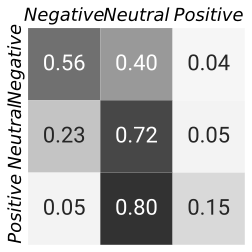

In [19]:
headlines['num_negative'] = headlines['sentence'].apply(count_from_list, word_list=lm_negative)
headlines['num_positive'] = headlines['sentence'].apply(count_from_list, word_list=lm_positive)

headlines['lm_dictionary'] = headlines.apply(get_sentiment, axis=1)

# Output
accuracy_f1_score(headlines['label'], headlines['lm_dictionary'])
plot_confusion_matrix(headlines['label'], headlines['lm_dictionary'])

### FinBERT

100%|██████████| 7/7 [00:02<00:00,  3.16it/s]
Accuracy: 54.36%
F1-score: 54.81%


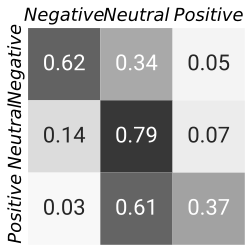

In [20]:
# Preprocess
input_ids, token_type_ids, attention_masks = preprocess_for_finbert(headlines['sentence'], vocab_file=FINBERT_VOCAB)
dataset = TensorDataset(input_ids, token_type_ids, attention_masks)
dataloader = DataLoader(dataset, batch_size=64)

# Predict
headlines['FinBERT'] = finbert_predict(finbert, dataloader)

# Output
accuracy_f1_score(headlines['label'], headlines['FinBERT'])
plot_confusion_matrix(headlines['label'], headlines['FinBERT'])

### Output

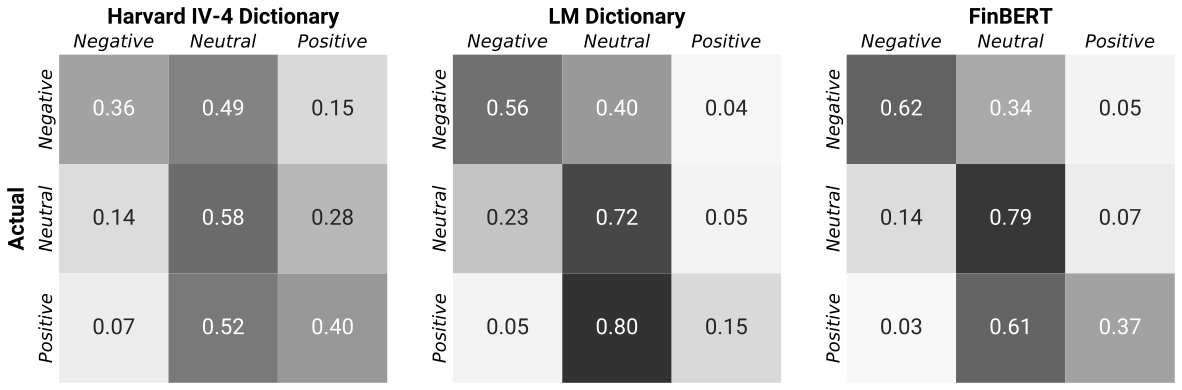

In [21]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 8), facecolor='w')
plot_confusion_matrix(headlines['label'], headlines['iv4_dictionary'], xlabel='Harvard IV-4 Dictionary', ylabel='Actual', ax=axes[0])
plot_confusion_matrix(headlines['label'], headlines['lm_dictionary'], xlabel='LM Dictionary', ax=axes[1])
plot_confusion_matrix(headlines['label'], headlines['FinBERT'], xlabel='FinBERT', ax=axes[2])
fig.savefig(os.path.join('3_output', 'figures', 'fiqa_cm.pdf'), bbox_inches='tight')

## Posts
### IV-4 Harvard

Accuracy: 32.15%
F1-score: 38.04%


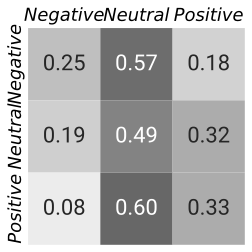

In [22]:
posts['num_negative'] = posts['sentence'].apply(count_from_list, word_list=iv4_negative)
posts['num_positive'] = posts['sentence'].apply(count_from_list, word_list=iv4_positive)

posts['iv4_dictionary'] = posts.apply(get_sentiment, axis=1)

# Output
accuracy_f1_score(posts['label'], posts['iv4_dictionary'])
plot_confusion_matrix(posts['label'], posts['iv4_dictionary'])

Accuracy: 28.59%
F1-score: 32.96%


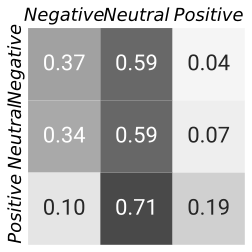

In [23]:
posts['num_negative'] = posts['sentence'].apply(count_from_list, word_list=lm_negative)
posts['num_positive'] = posts['sentence'].apply(count_from_list, word_list=lm_positive)

posts['lm_dictionary'] = posts.apply(get_sentiment, axis=1)

# Output
accuracy_f1_score(posts['label'], posts['lm_dictionary'])
plot_confusion_matrix(posts['label'], posts['lm_dictionary'])

### FinBERT

100%|██████████| 11/11 [00:03<00:00,  3.28it/s]
Accuracy: 43.26%
F1-score: 50.64%


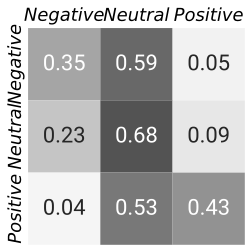

In [24]:
# Preprocess
input_ids, token_type_ids, attention_masks = preprocess_for_finbert(posts['sentence'], vocab_file=FINBERT_VOCAB)
dataset = TensorDataset(input_ids, token_type_ids, attention_masks)
dataloader = DataLoader(dataset, batch_size=64)

# Predict
posts['FinBERT'] = finbert_predict(finbert, dataloader)

# Output
accuracy_f1_score(posts['label'], posts['FinBERT'])
plot_confusion_matrix(posts['label'], posts['FinBERT'])

### Output

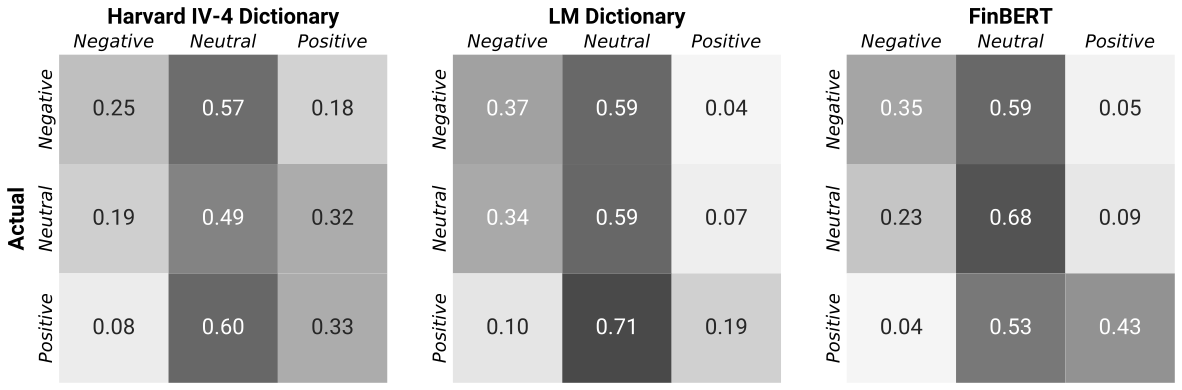

In [22]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 8), facecolor='w')
plot_confusion_matrix(posts['label'], posts['iv4_dictionary'], xlabel='Harvard IV-4 Dictionary', ylabel='Actual', ax=axes[0])
plot_confusion_matrix(posts['label'], posts['lm_dictionary'], xlabel='LM Dictionary', ax=axes[1])
plot_confusion_matrix(posts['label'], posts['FinBERT'], xlabel='FinBERT', ax=axes[2])
fig.savefig(os.path.join('3_output', 'figures', 'fiqa_posts_cm.pdf'), bbox_inches='tight')

---
# Analysis

In [23]:
def seach_sentences(df, label, dictionary, finbert):
    return df.loc[(df['label'] == label) &
                  (df['lm_dictionary'] == dictionary) &
                  (df['FinBERT'] == finbert), 'sentence']

In [24]:
with pd.option_context('display.max_colwidth', -1):
    display(seach_sentences(headlines, 'positive', 'negative', 'positive'))

855     glencore fight back over debt fears lifts shares          
1734    companiesfresnillo shares jump 8 as silver price breaks 21
Name: sentence, dtype: object

In [25]:
with pd.option_context('display.max_colwidth', -1):
    display(seach_sentences(posts, 'positive', 'negative', 'positive'))

14899    ymi long setup closed above the 20ma macd cross november catalyst                                                                     
14924    sppibuilding rs sweet i want this to break a new 52week the earnings growth justifies way higher                                      
15533    rcon some upside today this thing is severe low float if there is catalyst for this guy it can run                                    
15716    save breaking its downtrend line on increasing volume a move above 2057 could see more upside                                         
15908    osur up 33 since 6 25 buy signal resistance 533 expect 1 pullback 2nd half of day or 2 break abov 533 continue rally for 4 5 days     
16398    aapl downgrade is bias this stock is a buy                                                                                            
16966    tnh looks like an explosive setup if it can break the 20ema and 105 level                                                      

In [26]:
with pd.option_context('display.max_colwidth', -1):
    display(seach_sentences(headlines, 'negative', 'positive', 'negative'))

263     rbi surprises street sensex pares gains after hitting mount 30k
1052    us dollar wipes out sales gains for sabmiller                  
Name: sentence, dtype: object

In [27]:
with pd.option_context('display.max_colwidth', -1):
    display(seach_sentences(posts, 'negative', 'positive', 'negative'))

14867    i am not optimistic about amzn both fundementals and charts look like poopoo this quarter
Name: sentence, dtype: object